### Siamese Classifier

In [1]:
from Tumor_Classifier_Utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# loading in data
train, train_y, val, val_y, test, test_y, N, num_classes = load_data(64)


print(train.shape)
print(val.shape)
print(test.shape)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(2450, 64, 64, 1)
(350, 64, 64, 1)
(283, 64, 64, 1)
(2450, 1)
(350, 1)
(283, 1)


In [3]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def PairGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = GetSiameseData(imgs, labels, batch_size)
        yield [image_a, image_b], label

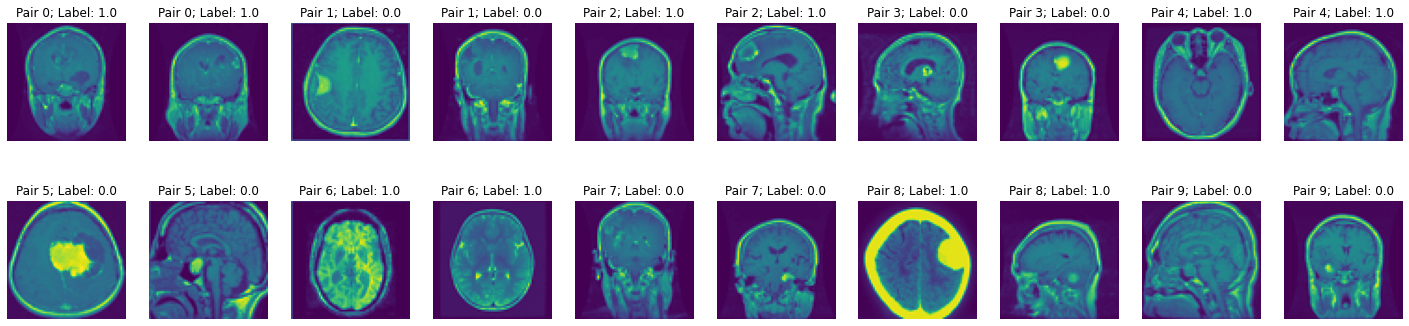

In [4]:
test_gen = PairGenerator(train, train_y, 10)
x, y = next(test_gen)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    ax.axis('off')
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))  
    ax.axis('off')

## The Network

In [5]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [6]:
embedding_size = 32
dummy_input = keras.Input((N, N, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')
base_network.summary()

Model: "SiameseBranch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 8)         0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 64, 64, 8)        0         
 ropout2D)                                           

In [7]:
input_a = keras.Input((N, N, 1), name='InputA')
input_b = keras.Input((N, N, 1), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

In [8]:
combined = layers.concatenate([embedding_a, embedding_b])
combined = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

siamese_network = keras.Model([input_a, input_b], output, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputA (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 InputB (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 SiameseBranch (Functional)     (None, 32)           2124920     ['InputA[0][0]',                 
                                                                  'InputB[0][0]']                 
                                                                                                  
 concatenate (Concatenate)      (None, 64)           0           ['SiameseBranch[0][0

In [9]:
keras.utils.plot_model(siamese_network, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
siamese_network.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [11]:
batch_size = 128
training_gen = PairGenerator(train, train_y, batch_size)

siamese_test_x, siamese_test_y = GetSiameseData(test, test_y, 128)

classWeights = class_weights()
history = siamese_network.fit(training_gen, steps_per_epoch = 2000 // batch_size, epochs=100, validation_data = (siamese_test_x, siamese_test_y), class_weight=classWeights)

Epoch 1/100
15/15 [==============================] - 7s 57ms/step - loss: 1.0349 - accuracy: 0.5073 - val_loss: 0.7174 - val_accuracy: 0.5000
Epoch 2/100
15/15 [==============================] - 0s 26ms/step - loss: 0.9770 - accuracy: 0.5099 - val_loss: 0.7507 - val_accuracy: 0.5000
Epoch 3/100
15/15 [==============================] - 0s 25ms/step - loss: 0.9775 - accuracy: 0.5125 - val_loss: 0.7173 - val_accuracy: 0.5000
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 0.9457 - accuracy: 0.5250 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 5/100
15/15 [==============================] - 0s 25ms/step - loss: 0.9005 - accuracy: 0.5589 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 6/100
15/15 [==============================] - 0s 26ms/step - loss: 0.8938 - accuracy: 0.5859 - val_loss: 0.7049 - val_accuracy: 0.5000
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 0.8660 - accuracy: 0.6026 - val_loss: 0.7234 - val_accuracy: 0.5000
Epoch 

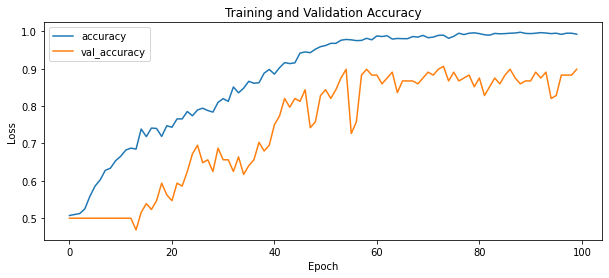

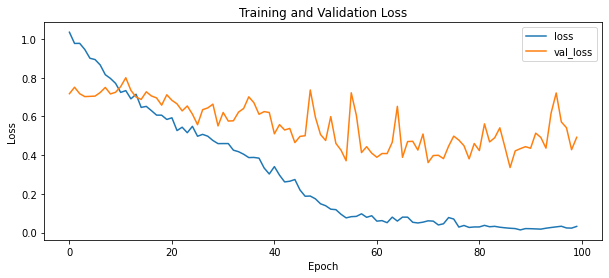

In [12]:
plot_loss(history)

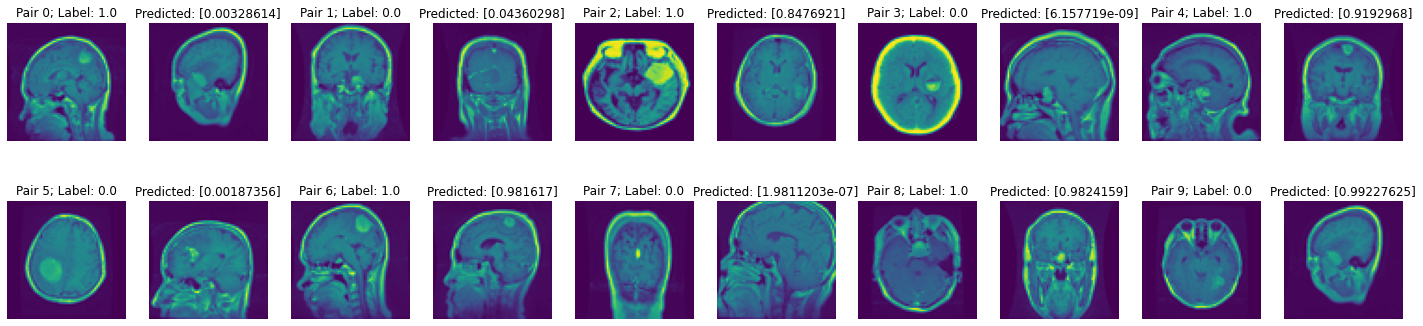

In [13]:
x, y = GetSiameseData(test, test_y, 10)
res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    ax.axis('off')
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))
    ax.axis('off')

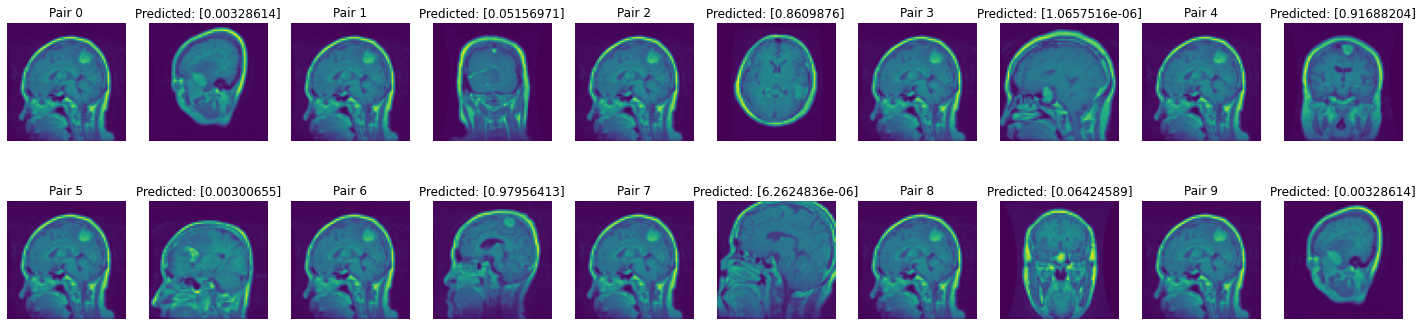

In [14]:
for i in range(10):
    x[0][i,:] = x[0][0,:]

res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i))
    ax.axis('off')
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))
    ax.axis('off')

c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


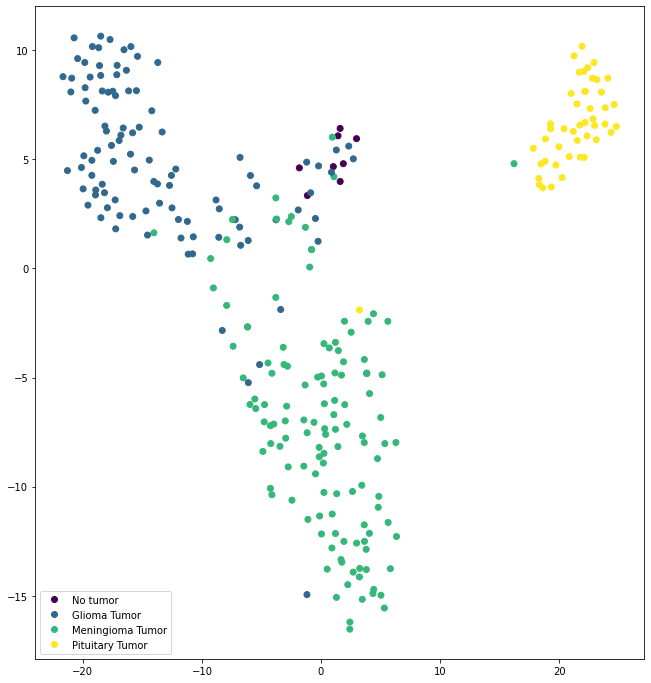

In [19]:
embeddings = base_network.predict(test)
tsne_embeddings = TSNE(n_components=2,random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 2, 1)
labels = ['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']
scatter = ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_y.flatten());
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
'''
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(30, 270)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_y.flatten());'''
plt.show()

[array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.00847458],
         [0.00423729],
         [0.00847458]],

        [[0.01271186],
         [0.01271186],
         [0.01271186],
         ...,
         [0.01694915],
         [0.01271186],
         [0.01271186]],

        [[0.01694915],
         [0.01694915],
         [0.01694915],
         ...,
         [0.01694915],
         [0.01271186],
         [0.01271186]],

        ...,

        [[0.03813559],
         [0.04237288],
         [0.02542373],
         ...,
         [0.02118644],
         [0.01694915],
         [0.02966102]],

        [[0.02542373],
         [0.02118644],
         [0.02118644],
         ...,
         [0.01694915],
         [0.01694915],
         [0.02542373]],

        [[0.        ],
         [0.00423729],
         [0.00423729],
         ...,
         [0.00847458],
         [0.00847458],
         [0.00847458]]],


       [[[0.        ],
         [0.        ],
         [0.0

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (4).

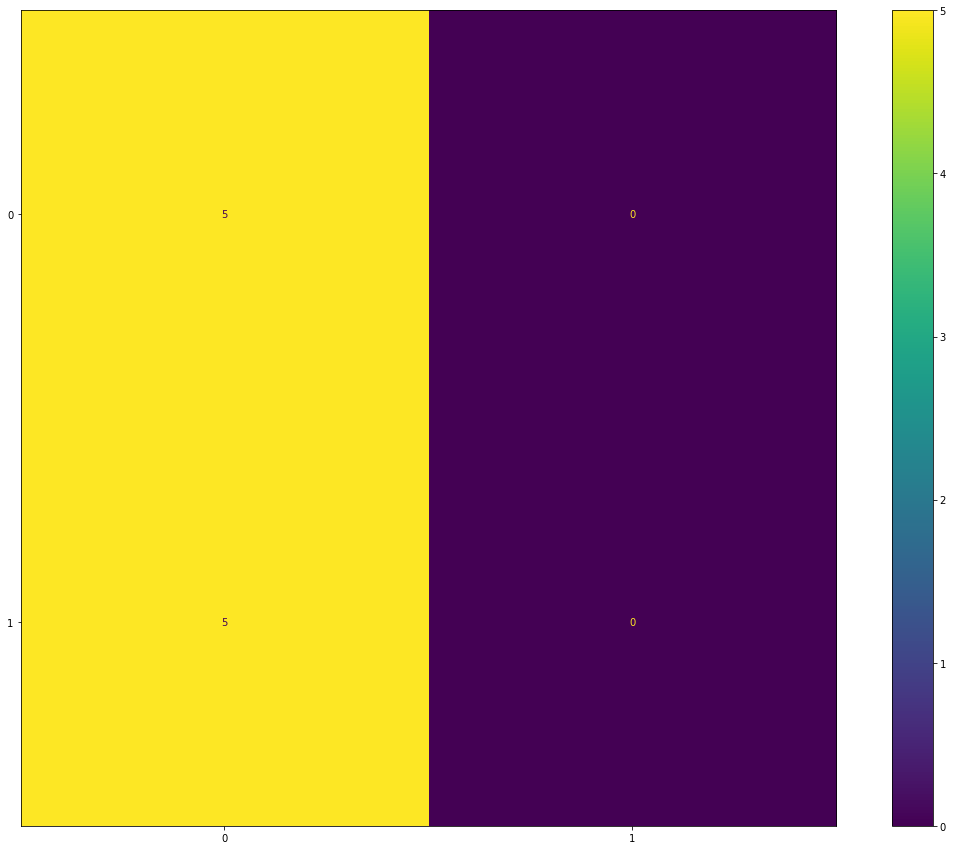

In [18]:
x, y = GetSiameseData(test, test_y, 10)
print(x, y)

fig = plt.figure(figsize=[18, 6])    
pred = siamese_network.predict(x)
indexes = tf.argmax(pred, axis=1)
print(indexes)
cm = confusion_matrix(y, indexes)
print(cm)

ax = fig.add_subplot(1, 1, 1)
labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
c = ConfusionMatrixDisplay(cm, display_labels=labels)
c.plot(ax = ax)
ax.set_title('Testing data confusion matrix')

print(classification_report(siamese_test_y, indexes))
